# Using CHARMM-GUI + MoSDeF + GROMACS + MDTraj
This workflow covers obtaining pre-parametrized structures via CHARMM-GUI,
initializing a system using mBuild, writing the appropriate input files for GROMACS,
running a simulation with GROMACS, and analyzing a trajectory with MDTraj

Outside of the scope of this work is using CHARMM-GUI, 
but we will assume we have designed and parametrized an ethane molecule via CHARMM-GUI
based on the CHARMM force field. The resultant output has relevant parameter and input files for
OpenMM, NAMD, CHARMM, and GROMACS. We are also given some structural coordinates for an ethane molecule. 

In this workflow, we are working with the GROMACS simulation package, so we are interested in the ITP files,
`files/ETHA.itp` and `files/charmm36.itp`, as well as the MOL2 file, `files/ethane.mol2`. 

The ITP files contain all the relevant force field information for a simulation, 
while the MOL2 file serves as a prototype for constructing an `mb.Compound`

In [38]:
import mbuild as mb

## Constructing our mb.Compound subclass
In this situation, we do not need to construct particles and overlap ports. 
Instead, we can load coordinates/bonding information from the MOL2 file.
We can also set the name of the compound to be consistent with `files/ETHA.itp`

In [65]:
class charmm_ethane(mb.Compound):
    def __init__(self):
        super(charmm_ethane, self).__init__()
        mb.load('files/ethane.mol2', compound=self)
        self.name='ETHA'

## Re-using this class

We will use mBuild functionality to construct a larger mb.Compound by filling a box with these ethane molecules.

In [40]:
prototype = charmm_ethane()
n_ethane = 100
ethane_box = mb.fill_box(compound=prototype, n_compounds=n_ethane, density=1)

/Users/ayang41/Programs/mdtraj/mdtraj/formats/mol2.py:203: FutureWarning: read_table is deprecated, use read_csv instead.
  index_col=0, header=None, sep="\s+", engine='python')


## Writing coordinates to disk
We can `save` this compound to disk in a variety of file formats. Since we are performing a GROMACS simulation, we will save the coordinates to a `gro` file, additionally specifying residue names.

In [42]:
ethane_box.save('box.gro', residues=['ETHA'], overwrite=True)

## Writing force field information to disk
By using the #include statement functionality in gromacs, we can write a fairly simple `top` file.
This `top` file will pull force field parameters from `files/charmm36.itp` and `files/ETHA.itp`.

In this example, the use of `ITP` files helps streamline the force field parametrization process
because these compounds were already parametrized

In [43]:
with open('box.top', 'w') as f:
    f.write("#include \"files/charmm36.itp\" \n")
    f.write("#include \"files/ETHA.itp\" \n")
    f.write("[ System ] \n")
    f.write('mBuild box of ethane\n')
    f.write("[ Molecules ] \n")
    f.write("{} {}".format(prototype.name, n_ethane))

## Perform energy minimization and NPT simulation in GROMACS
This is an uninteresting system with very few timesteps, but we will continue with the simulation steps

In [44]:
!gmx grompp -f files/em.mdp -c box.gro -p box.top -o em -maxwarn 1

                      :-) GROMACS - gmx grompp, 2018.1 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS de

In [45]:
!gmx mdrun -deffnm em

                      :-) GROMACS - gmx mdrun, 2018.1 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS dev

In [54]:
!gmx grompp -f files/npt.mdp -c em.gro -p box.top -o npt

                      :-) GROMACS - gmx grompp, 2018.1 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS de

In [55]:
!gmx mdrun -deffnm npt

                      :-) GROMACS - gmx mdrun, 2018.1 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS dev

## Analyzing trajectories with MDTraj
After performing a simulation, we can read the relevant trajectory files into an `mdtraj.Trajectory` object,
an in-memory, digital representation of a trajectory.

MDTraj has a variety of functionality, but for convenience we will just compute the density of the system

In [56]:
import mdtraj
traj = mdtraj.load('npt.xtc', top='npt.gro')
rho = mdtraj.density(traj)

## Validation and comparison to reference data
A reference density-timeseries is located in `files/rho.dat`. 
We can load the reference data and compare to our simulated reference data.

Text(0.5, 0, 'Time (ps)')

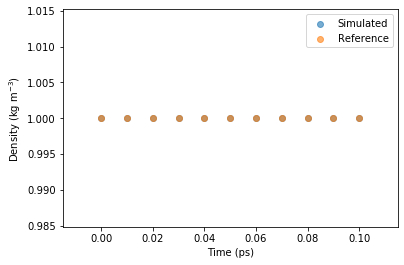

In [64]:
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

ref = np.loadtxt('ref/rho.dat')
fig, ax = plt.subplots(1,1)
ax.scatter(traj.time, rho, label='Simulated', alpha=0.6)
ax.scatter(ref[:,0], ref[:,1], label='Reference', alpha=0.6)
ax.legend()
ax.set_ylabel(r"Density (kg m$^{{-3}}$)")
ax.set_xlabel("Time (ps)")

## Notes
Because of how short the simulation was run, there was actually no box-resizing performed, so the density is constant and the same as how we specified in the mBuild steps (we specified a density of 1, which is consistent with the non-box-altered simulation)

# Summary
We have neatly conducted and analyzed a simulation from start to finish. 
We have built and parametrized our system using CHARMM-GUI and mBuild, simulated using GROMACS, and analyzed using MDTraj. 
Furthermore, there is clear room to work with other force field parameters, molecules, simulation engines, and analysis packages.